In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


import statsmodels.api as sm

In [2]:
db_name = 'capstone'
db_host = 'localhost'
db_user = 'root'
db_password = 'rootroot'

connection = pymysql.connect(host=db_host,
                             user=db_user,
                             password=db_password,
                             db=db_name)

In [3]:
cursor = connection.cursor()

# Read data from the MySQL database into a Pandas DataFrame
df = pd.read_sql('SELECT * FROM gm_logs', connection)
#cursor.execute('SELECT * FROM phy_err')
#customers = cursor.fetchall()
#df = pd.DataFrame(customers)

# Close the cursor and connection
cursor.close()
connection.close()
#gameid - gameinfo
#teamid - teamstats
# visteam,hometeam,site,number,daynihgt,innings,htbf,attendance,gametype - gameinfo
# b_sh, b_sf, b_hbp,  b_iw , b_sb, b_cs, b_gdp, b_xi , p_wp , p_bk, d_e - teamstats

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178627 entries, 0 to 178626
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   playdate     178627 non-null  object 
 1   day          178627 non-null  object 
 2   hteam        178627 non-null  object 
 3   daynight     178627 non-null  object 
 4   park_id      178627 non-null  object 
 5   number       178627 non-null  int64  
 6   v_hit_pitch  178625 non-null  float64
 7   v_sh         178625 non-null  float64
 8   v_in_walks   178625 non-null  float64
 9   v_stlbase    178625 non-null  float64
 10  v_cau_stl    178625 non-null  float64
 11  v_wld_ptc    178625 non-null  float64
 12  v_balks      178625 non-null  float64
 13  v_assists    178625 non-null  float64
 14  v_errors     178625 non-null  float64
 15  v_pballs     178625 non-null  float64
 16  v_win_val    178627 non-null  int64  
dtypes: float64(10), int64(2), object(5)
memory usage: 23.2+ MB


In [5]:
df.isna().sum()

playdate       0
day            0
hteam          0
daynight       0
park_id        0
number         0
v_hit_pitch    2
v_sh           2
v_in_walks     2
v_stlbase      2
v_cau_stl      2
v_wld_ptc      2
v_balks        2
v_assists      2
v_errors       2
v_pballs       2
v_win_val      0
dtype: int64

In [6]:
df.fillna(method='ffill',inplace=True)

In [7]:

#df['attendance']  = df['attendance'].astype(str).astype('float64') 
#set default innings
#df['innings'].fillna(9,inplace = True)
# htbf replace with mode - away team
#df['htbf'].fillna(1,inplace = True)
# Convert the attedance column to an integer column
#df['attendance'] = pd.to_numeric(df['attendance'],errors='coerce',downcast='integer')
#replace median attendance
#df['attendance'].fillna(df['attendance'].mode,inplace = True)
# Convert the attedance column to an integer column
#df['attendance'] = pd.to_numeric(df['attendance'],errors='coerce',downcast='integer')
#Replace daynight with day as deafult
#df['daynight'].replace('', 'day', inplace=True)


In [8]:
#df.convert_dtypes()

In [9]:
#df.reset_index()

In [10]:
df.head()

,playdate,day,hteam,daynight,park_id,number,v_hit_pitch,v_sh,v_in_walks,v_stlbase,v_cau_stl,v_wld_ptc,v_balks,v_assists,v_errors,v_pballs,v_win_val
0,1915-05-29,Sat,PHA,D,PHI11,2,0.0,3.0,0.0,1.0,1.0,0.0,0.0,17.0,3.0,0.0,1
1,1906-08-13,Mon,PHI,D,PHI09,0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,10.0,1.0,0.0,1
2,1906-08-15,Wed,BOS,D,BOS06,0,1.0,5.0,-1.0,3.0,-1.0,0.0,0.0,12.0,0.0,1.0,0
3,1911-08-13,Sun,SLA,D,STL07,1,0.0,0.0,-1.0,1.0,-1.0,0.0,0.0,13.0,4.0,0.0,0
4,1911-08-13,Sun,SLA,D,STL07,2,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,11.0,1.0,0.0,0


In [11]:
#df['hteam_win'] = np.where(df['hometeam'].eq(df['wteam']), "win", "lose")

In [12]:
#df['hteam_win'].value_counts()

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

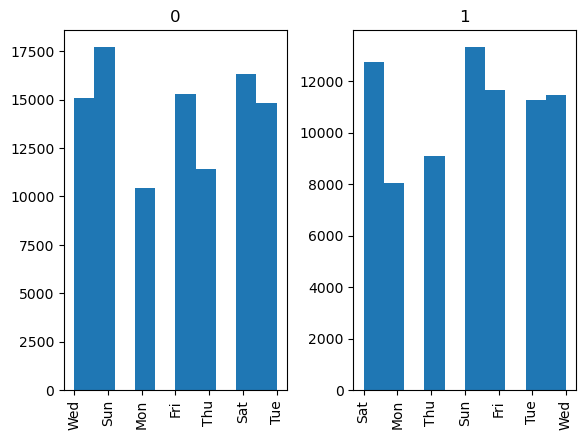

In [13]:
df.hist(column='day', by='v_win_val')

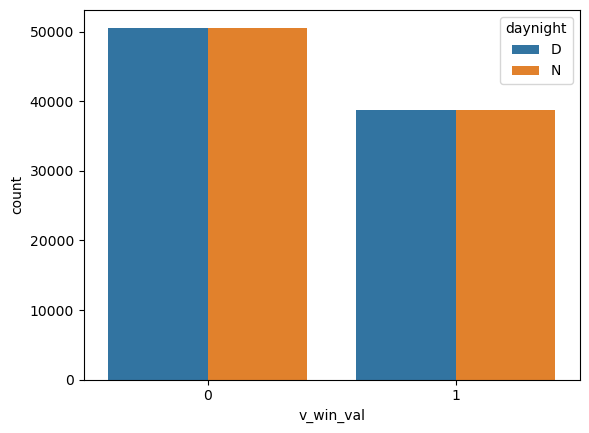

In [14]:
# Create a bar plot
#sns.barplot(x = "daynight", y = "hteam_win", data = df)
# Create a count plot
sns.countplot(x='v_win_val', hue='daynight', data=df)

# Display the plot
plt.show()

In [15]:
df['playdate'] = pd.to_datetime(df['playdate'])

In [16]:
# Get dummies for the 'A' column
dummies = pd.get_dummies(df['v_win_val'], prefix='vwin_')
# Add the dummy columns to the dataframe
df = pd.concat([df, dummies], axis=1)

In [17]:
# Chnage catgories to numeric
#df['daynight'].replace({'day' : 1, 'night' : 0},inplace=True)
# Get dummies for the 'A' column
dummies = pd.get_dummies(df['daynight'], prefix='daynight_')
# Add the dummy columns to the dataframe
df = pd.concat([df, dummies], axis=1)

In [18]:
# Get dummies for the 'A' column
dummies = pd.get_dummies(df['day'], prefix='day_')
# Add the dummy columns to the dataframe
df = pd.concat([df, dummies], axis=1)

In [19]:
#pd.get_dummies(df, columns=['v_win_val'], prefix='binary_' , inplace = True)
#df_dummies = pd.get_dummies(df['v_win_val'], prefix='vteam_')

In [20]:
# create dummy variables
#dummies_game_type = pd.get_dummies(df['gametype'], dtype=int, prefix='gtype')

# concatenate the dummy variables to the original dataframe
#df = pd.concat([df, dummies_game_type], axis=1)

In [21]:
#imbalanace Traget Variable 
df['v_win_val'].value_counts(normalize=True)

v_win_val
0    0.565917
1    0.434083
Name: proportion, dtype: float64

In [22]:
# drop some coulmns and create a new dataframe
model_data = df.drop(['playdate', 'day', 'hteam', 'daynight', 'v_win_val','park_id'], axis=1)

In [23]:
# coor, Heatmap
model_data =  model_data.astype(int)

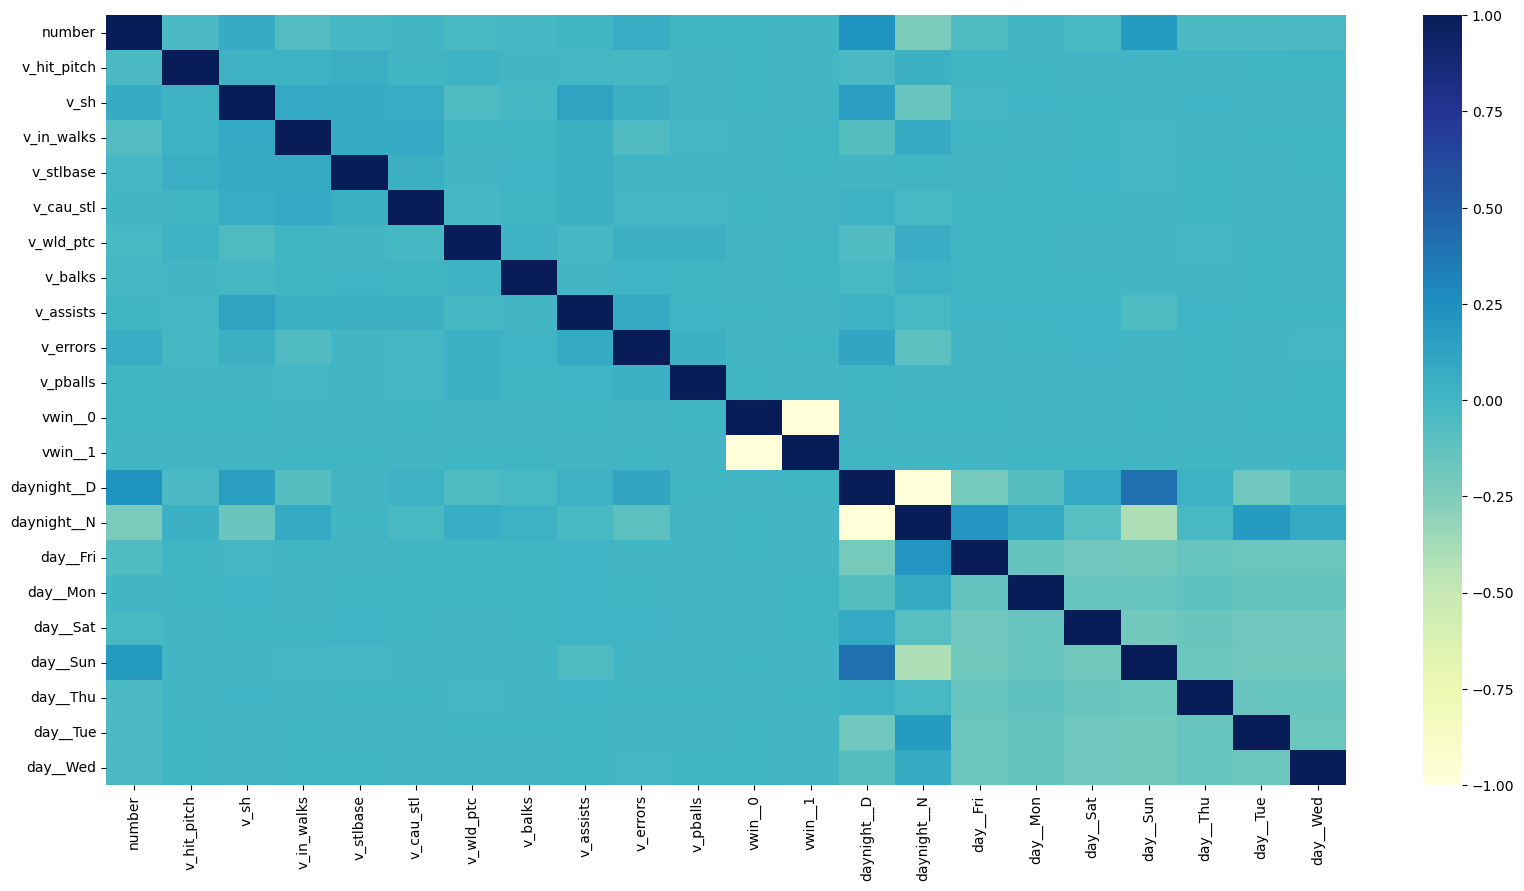

In [24]:
# Let's create the correlation matrix 
corr = model_data.corr()
plt.figure(figsize=(20,10))

# Create a heatmap
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [30]:
# let's drop for multi co-linear
model_data.drop(columns=['vwin__0','daynight__N'] , inplace=True)
# let's drop one column for multi co-linear
model_data.drop(columns=['day__Wed'] , inplace=True)

In [31]:

# build a logistic regression model
X = model_data.drop('vwin__1', axis=1)
X_withconstant = sm.add_constant(X)
y = model_data['vwin__1']

In [32]:
model_data.isna().sum()

number         0
v_hit_pitch    0
v_sh           0
v_in_walks     0
v_stlbase      0
v_cau_stl      0
v_wld_ptc      0
v_balks        0
v_assists      0
v_errors       0
v_pballs       0
vwin__1        0
daynight__D    0
day__Fri       0
day__Mon       0
day__Sat       0
day__Sun       0
day__Thu       0
day__Tue       0
dtype: int64

In [33]:
model = sm.Logit(y, X_withconstant)
model = model.fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.684372
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                vwin__1   No. Observations:               178627
Model:                          Logit   Df Residuals:                   178608
Method:                           MLE   Df Model:                           18
Date:                Mon, 25 Mar 2024   Pseudo R-squ.:               8.803e-05
Time:                        13:13:10   Log-Likelihood:            -1.2225e+05
converged:                       True   LL-Null:                   -1.2226e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2538
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2722      0.020    -13.593      0.000      -0.311      -0.233
number         -0.0016      0.009     -0.180      0.857      -0.019       0.016
v_hit_pitch    -0.0025      0.009     -0.277      0.782      -0.020       0.015
v_sh           -0.0008      0.006     -0.132      0.895      -0.013       0.012
v_in_walks      0.0039      0.009      0.453      0.650      -0.013       0.021
v_stlbase       0.0080      0.005      1.520      0.129      -0.002       0.018
v_cau_stl      -0.0040      0.008     -0.507      0.612      -0.019       0.011
v_wld_ptc       0.0044      0.009      0.513      0.608      -0.012       0.021
v_balks         0.0232      0.024      0.975      0.329      -0.023       0.070
v_assists      -0.0015      0.001     -1.053      0.292      -0.004       0.001
v_errors        0.0085      0.005      1.753      0.080      -0.001       0.018
v_pballs       -0.0094      0.016     -0.576      0.565      -0.041       0.023
daynight__D     0.0023      0.011      0.198      0.843      -0.020       0.025
day__Fri        0.0038      0.018      0.219      0.827      -0.031       0.038
day__Mon        0.0114      0.019      0.591      0.554      -0.026       0.049
day__Sat        0.0265      0.017      1.534      0.125      -0.007       0.060
day__Sun       -0.0108      0.018     -0.601      0.548      -0.046       0.025
day__Thu        0.0458      0.019      2.435      0.015       0.009       0.083
day__Tue        0.0006      0.018      0.032      0.974      -0.034       0.035
===============================================================================
"""

In [34]:
# getting probabiistic and binary predictions
model_predictions_prob = model.predict(X_withconstant)
model_predictions_binary = np.where(model_predictions_prob>0.5,1,0)

In [35]:
# How many did we predict right?
(model_predictions_binary == model_data['vwin__1']).sum()

101088

In [37]:
# How many data points to we have?
len(model_data['vwin__1'])

178627

In [38]:
print("The classification accuracy is:", (101088/178627)*100 , "%")

The classification accuracy is: 56.59166867270905 %
